# Translation with a Sequence to Sequence Network

In this project we will be teaching a neural network to translate 
from French to English.

[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .

… to varying degrees of success.

Read it here  https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

There are two rnn which transform one seq to another seq an encoder n/w transform a input sequence into a vector a decoder n/w transform the vector into a new sequence to improve upon this model we will use the attention mechanism

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading data files 

In [2]:
"""

The English to French pairs are too big to include in the repo, 
so download to data/eng-fra.txt before continuing. The file is 
a tab separated list of translation pairs:

I am cold.    J'ai froid.

Similar to the character encoding used in the character-level RNN we will
be representing each word in a language as a one-hot vector or a giant 
vector of zeros except for a single one (at the index of the word).

Compared to the dozens of characters that might exist in a language, 
there are many many more words, so the encoding vector is much larger. 
We will however cheat a bit and trim the data to only use a few 
thousand words per language.

we need a unique index per word to use as the inputs and targets of the 
networks later.

We will be using a helper function called Lang which has these two utilities

word --> index (word2index)
index -->word (index2word)
count of each word (word2count)


"""


SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        
        """
        
        initialize the index2word as 0 = SOS 1 = EOS
        initialize no of words as n_words = 2
        
        """
        
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        
        """
        
        divide the sentence into words 
        and send each word through the function
        addWord
        
        the addWord does this 
        gets a word 
        checks if the word is NOT in word2index 
        (a) if no need a new index for this word 
        and hence assigns a index to this new word 
        
        also increase the count of words i.e. the no
        of times the word has occured in the sentence 
        (this is given by word2count)
        
        also update index2word i.e., which index means which word ?
        
        finally increase the no of unique words 
        by updating n_words
        
        (b) if word is in word2index 
        just increase the count of word occurance in
        the sentence 
        
        """
        
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [3]:
# The files are all in Unicode, to simplify we will turn Unicode 
# characters to ASCII, make everything lowercase, and trim most 
# punctuation.


# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


In [4]:

"""

To read the data file we will split the file into lines, and then 
split lines into pairs. The files are all English → Other Language, 
so if we want to translate from Other Language → English I added 
the reverse flag to reverse the pairs.

"""

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs



In [5]:

"""

Since there are a lot of example sentences and we want to train
something quickly, we’ll trim the data set to only relatively 
short and simple sentences. Here the maximum length is 10 words (
that includes ending punctuation) and we’re filtering to sentences 
that translate to the form “I am” or “He is” etc. (accounting for 
apostrophes replaced earlier).

"""


MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]



The full process for preparing the data is:

    1. Read text file and split into lines, split lines into pairs
    2. Normalize text, filter by length and content
    3. Make word lists from sentences in pairs

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['je suis en retard .', 'i m late .']


# The Seq2Seq Model

In [7]:
"""

Read it here 
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#the-encoder

with a seq2seq model the encoder creates a single vector which 
in the ideal case encodes the meaning of the input sequence into a single 
vector - a single point in some N dimensional space of sentences 

Encoder a RNN that outputs some value for every word from the input
sentence and a hidden state and uses the hidden state for the next input 
word

[input] --> embedding --> [embedded]

[embedded], [prev_hidden] --> gru --> [output, hidden]

"""

class EncoderRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):        
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

    
"""

Decoder is another RNN that takes the encoder output vector(s) and 
outputs a sequence of words to create the translation.

in the simplest decoder we WILL use ONLY THE LAST OUTPUT OF THE ENCODER
this last output is sometimes called context vector as it encodes context
from the entire sequence
the context vector is used as the initial hidden state of the decoder 


at every step of the decoding the decoder is given an input token and 
hidden state
he initial input token is start of string <SOS> 
and the first hidden state is the context vector 
(the encoders LAST HIDDEN STATE)

[input] --> embedding --> relu --> 
o/p of [relu], [prev_hidden] --> gru 
gru --> [out] --> softmax --> [output]
gru --> hidden

"""    
class DecoderRNN(nn.Module):
    
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# Training 
Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.


In [8]:
"""

I encourage you to train and observe the results of this model, 
but to save space we’ll be going straight for the gold and introducing 
the Attention Mechanism.

Let us look at the training data 

to train, for each pair, we will need an input tensor (indexes of the words in the input
sentence) and target tensor (indexes of the words in the target sentence). 

"""

def indexesFromSentence(lang, sentence):
    
    """
    split each sentence in words 
    and return the word2index for that word
    """
    
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    
    """
    each sentence will be split into words 
    each word index is retreived by using word2index
    finally the EOS_token is appended
    """
    
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    
    """
    pair[0] is the source sentence 
    pair[1] is the target sentence
    input_lang is the input language 
    output_lang is the output language 
    
    look at the input_tensor
    it will be divided into words 
    each word will be matched with the word's index
    and each index will be sent back
    and then appended with a EOS_token
    the same thing is for the target_tensor
    """
    
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)


# Training the Model

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.

“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - intuitively it has learned to represent the output grammar and can “pick up” the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation in the first place.

Because of the freedom PyTorch’s autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement. Turn teacher_forcing_ratio up to use more of it.


In [9]:
"""

this code is self explanatory

basically send each word in the source sentence through the 
encoder one by one 
keep sending back the encoder_hidden through the lstm, gru or rnn

the FINAL encoder_hidden will the CONTENT code fed to the 
decoder as theFIRST decoder_hidden

the decoder_input is the SOS TOKEN

The same thing is done for the decoder 
go on feeding the decoder_input and decoder_hidden to the decoder

fed back the decoder_hidden

regarding the decoder_input it can be of two types -- 

(a) since during training, you know what is the expected output
you can send the actual expected target i.e., target_tensor[di] 
as the decoder_input

THIS IS CALLED TEACHER FORCHING

(b) otherwise whatever is predicted by this step "t" is fed as 
input in the step "t+1"

look at these two lines 
topv, topi = decoder_output.topk(1)
decoder_input = topi.squeeze().detach()  # detach from history

if decoder_output is EOS token 
then stop

"""

teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
          decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)        

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.



In [10]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


The whole training process looks like this:

    Start a timer
    Initialize optimizers and criterion
    Create set of training pairs
    Start empty losses array for plotting

Then we call train many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.

In [11]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


# Plotting results

Plotting is done with matplotlib, using the array of loss values plot_losses saved while training.

In [12]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

# Evaluation

Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [13]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS
        decoder_hidden = encoder_hidden
        decoded_words = []        

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)            
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words


 We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [14]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


# Training and Evaluating

With all these helper functions in place (it looks like extra work, but it makes it easier to run multiple experiments) we can actually initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small dataset we can use relatively small networks of 256 hidden nodes and a single GRU layer. After about 40 minutes on a MacBook CPU we’ll get some reasonable results.

If you run this notebook you can train, interrupt the kernel, evaluate, and continue training later. Comment out the lines where the encoder and decoder are initialized and run trainIters again.


3m 11s (- 44m 42s) (5000 6%) 2.9461
5m 15s (- 34m 13s) (10000 13%) 2.4079
7m 21s (- 29m 27s) (15000 20%) 2.0707
9m 26s (- 25m 56s) (20000 26%) 1.8127
11m 33s (- 23m 6s) (25000 33%) 1.5835
13m 36s (- 20m 24s) (30000 40%) 1.4217
15m 39s (- 17m 53s) (35000 46%) 1.2672
17m 44s (- 15m 31s) (40000 53%) 1.1142
19m 48s (- 13m 12s) (45000 60%) 1.0186
21m 52s (- 10m 56s) (50000 66%) 0.9115
23m 54s (- 8m 41s) (55000 73%) 0.8305
25m 57s (- 6m 29s) (60000 80%) 0.7425
28m 2s (- 4m 18s) (65000 86%) 0.6420
30m 5s (- 2m 8s) (70000 93%) 0.5571
32m 11s (- 0m 0s) (75000 100%) 0.5330


<Figure size 432x288 with 0 Axes>

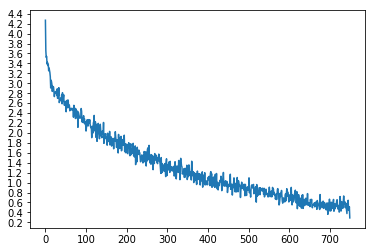

In [17]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 75000, print_every=5000)
#trainIters(encoder1, decoder1, 100, print_every=20)

In [18]:
evaluateRandomly(encoder1, decoder1)

> elle est jeune .
= she is young .
< she s young . <EOS>

> je suis heureux de vous avoir invite .
= i m glad i invited you .
< i m glad i invited you . <EOS>

> je suis grassouillette .
= i m chubby .
< i m chubby . <EOS>

> je connais bien tom .
= i m well acquainted with tom .
< i m fine with tom . <EOS>

> je ne suis pas un enfant .
= i m not a child .
< i m not a child . <EOS>

> je vais en australie .
= i m going to australia .
< i m going to . . <EOS>

> nous avons tous deux tort .
= we re both wrong .
< we re both wrong . <EOS>

> tu es tatillon .
= you re finicky .
< you re finicky . <EOS>

> nous sommes onze en tout .
= we are eleven in all .
< we re all in all . <EOS>

> je suis epuise .
= i m worn out .
< i am exhausted . <EOS>

